<a target="_blank" href="https://colab.research.google.com/drive/1uFyXOLLibGQKqvr8K7jaG_7S3V6oits2?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 🕷️ Research Agent with `scrapegraph`, `langgraph`, `tavily` and `MySQL`

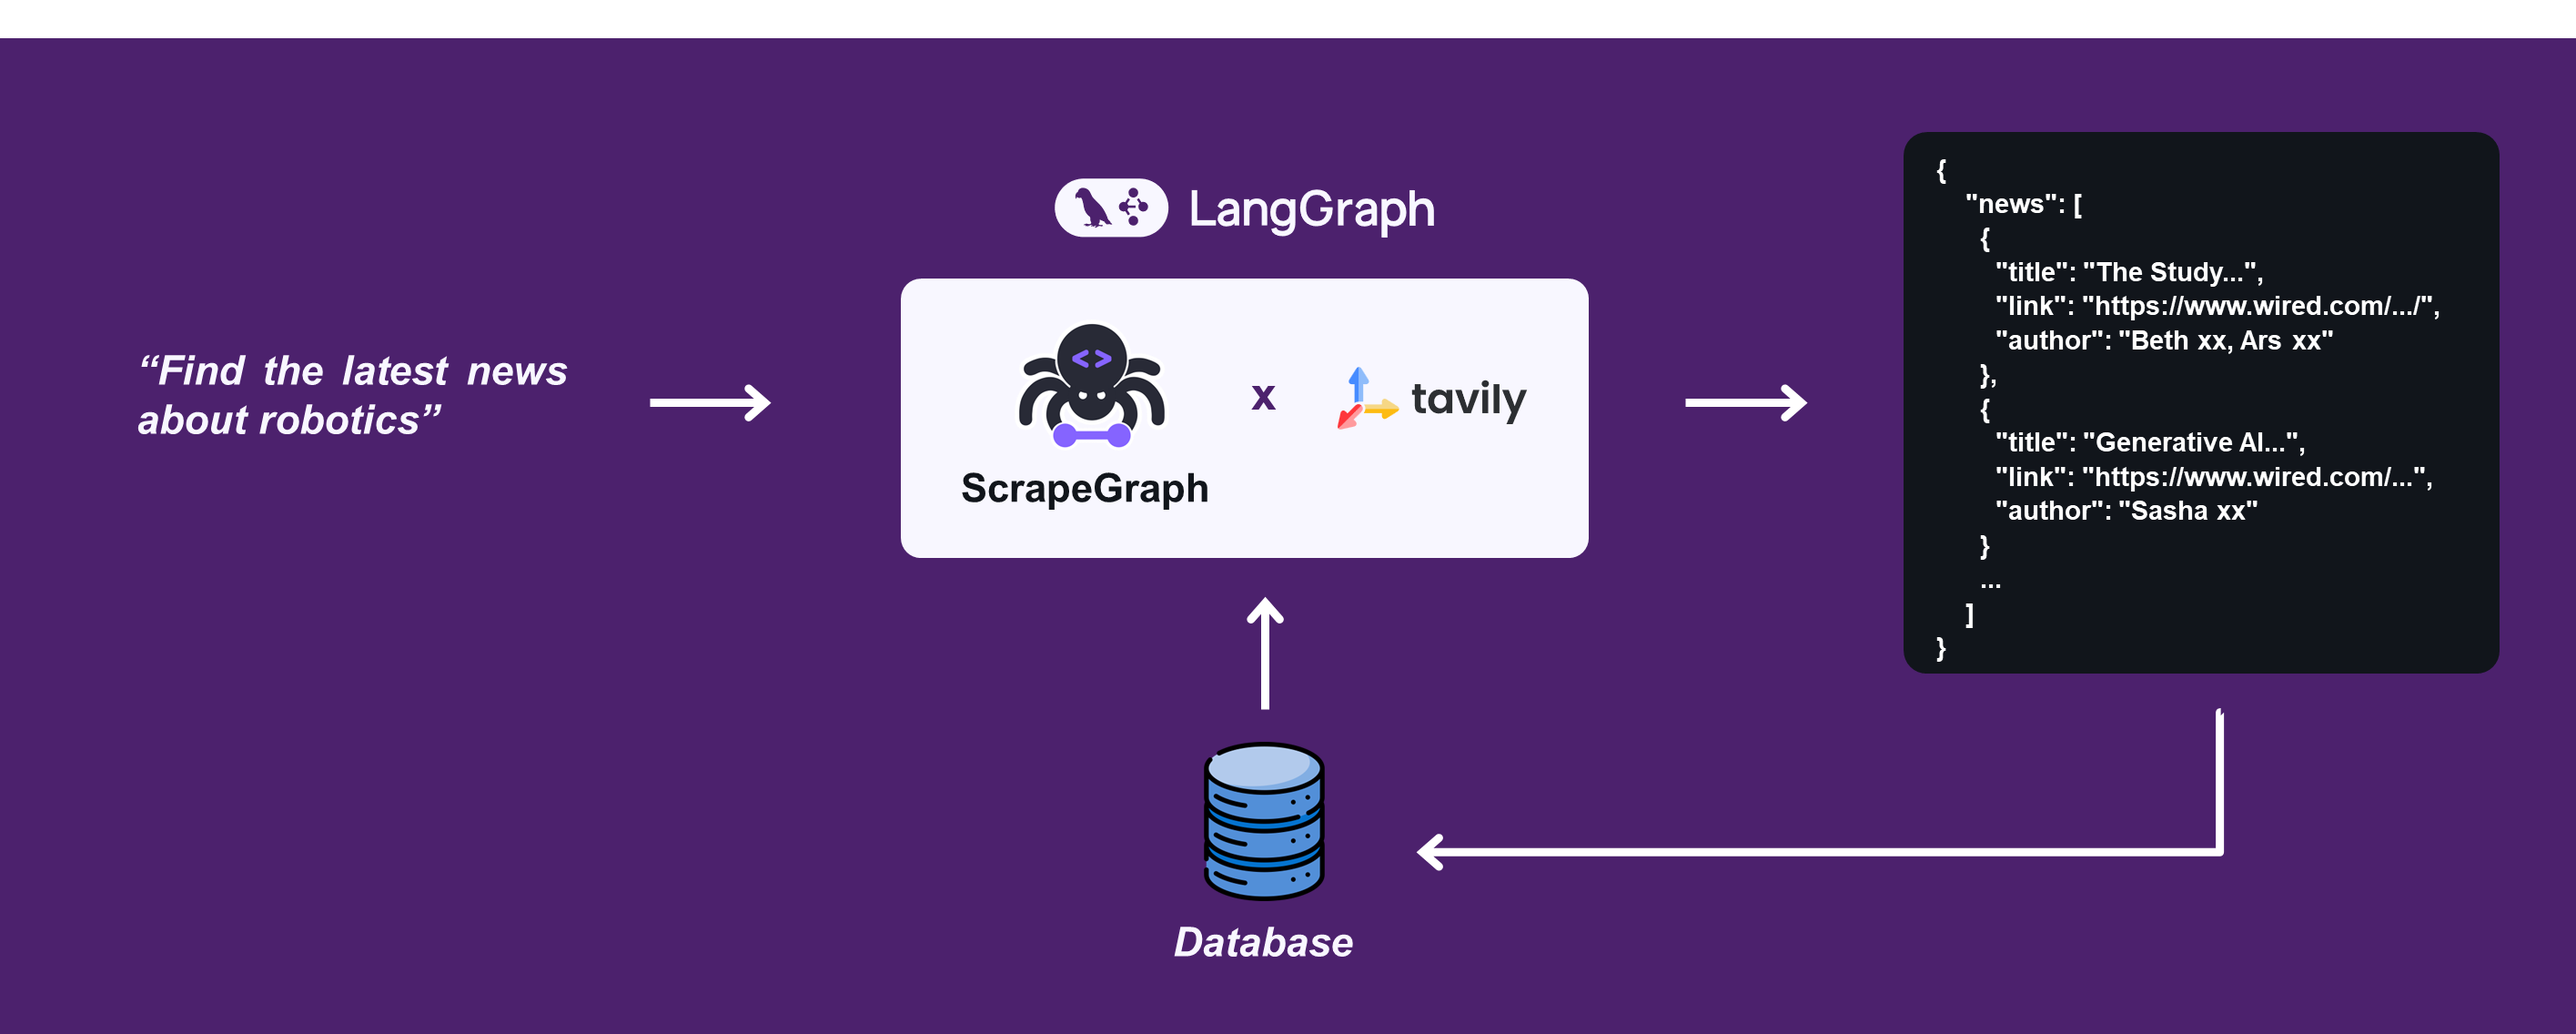

### 🔧 Install `dependencies`

In [1]:
%%capture
!pip install langgraph langchain-scrapegraph langchain-openai "langchain-community>=0.2.11" tavily-python

### 🔑 Import `ScrapeGraph`, `Tavily` and `OpenAI` API keys

You can find the Scrapegraph API key [here](https://dashboard.scrapegraphai.com/)

In [2]:
import getpass
import os

if not os.environ.get("SGAI_API_KEY"):
    os.environ["SGAI_API_KEY"] = getpass.getpass("Scrapegraph API key:\n")

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API key:\n")

Scrapegraph API key:
··········
Tavily API key:
··········
OpenAI API key:
··········


### 📝 Defining an `Output Schema` for Webpage Content Extraction


If you already know what you want to extract from a webpage, you can **define an output schema** using **Pydantic**. This schema acts as a "blueprint" that tells the AI how to structure the response.

<details>
  <summary>Pydantic Schema Quick Guide</summary>

Types of Schemas  

1. Simple Schema  
Use this when you want to extract straightforward information, such as a single piece of content.  

```python
from pydantic import BaseModel, Field

# Simple schema for a single webpage
class PageInfoSchema(BaseModel):
    title: str = Field(description="The title of the webpage")
    description: str = Field(description="The description of the webpage")

# Example Output JSON after AI extraction
{
    "title": "ScrapeGraphAI: The Best Content Extraction Tool",
    "description": "ScrapeGraphAI provides powerful tools for structured content extraction from websites."
}
```

2. Complex Schema (Nested)  
If you need to extract structured information with multiple related items (like a list of repositories), you can **nest schemas**.

```python
from pydantic import BaseModel, Field
from typing import List

# Define a schema for a single repository
class RepositorySchema(BaseModel):
    name: str = Field(description="Name of the repository (e.g., 'owner/repo')")
    description: str = Field(description="Description of the repository")
    stars: int = Field(description="Star count of the repository")
    forks: int = Field(description="Fork count of the repository")
    today_stars: int = Field(description="Stars gained today")
    language: str = Field(description="Programming language used")

# Define a schema for a list of repositories
class ListRepositoriesSchema(BaseModel):
    repositories: List[RepositorySchema] = Field(description="List of GitHub trending repositories")

# Example Output JSON after AI extraction
{
    "repositories": [
        {
            "name": "google-gemini/cookbook",
            "description": "Examples and guides for using the Gemini API",
            "stars": 8036,
            "forks": 1001,
            "today_stars": 649,
            "language": "Jupyter Notebook"
        },
        {
            "name": "TEN-framework/TEN-Agent",
            "description": "TEN Agent is a conversational AI powered by TEN, integrating Gemini 2.0 Multimodal Live API, OpenAI Realtime API, RTC, and more.",
            "stars": 3224,
            "forks": 311,
            "today_stars": 361,
            "language": "Python"
        }
    ]
}
```

Key Takeaways  
- **Simple Schema**: Perfect for small, straightforward extractions.  
- **Complex Schema**: Use nesting to extract lists or structured data, like "a list of repositories."  

Both approaches give the AI a clear structure to follow, ensuring that the extracted content matches exactly what you need.
</details>


In [3]:
from pydantic import BaseModel, Field
from typing import List

# Schema for a single news item
class NewsItemSchema(BaseModel):
    title: str = Field(description="Title of the news article")
    link: str = Field(description="URL to the news article")
    description: str = Field(description="Summary/description of the news article")

# Schema that contains a list of news items
class ListNewsSchema(BaseModel):
    news: List[NewsItemSchema] = Field(description="List of news articles with their details")

### 🚀 Initialize `scrapegraph` and `tavily` tools and `langgraph` prebuilt agent and run the `extraction`

Here we use `SmartScraperTool` to extract structured data using AI from a webpage.


> If you already have an HTML file, you can upload it and use `LocalScraperTool` instead.

You can find more info in the [official langchain documentation](https://python.langchain.com/docs/integrations/tools/scrapegraph/)



In [21]:
from langchain_scrapegraph.tools import SmartScraperTool
from langchain_community.tools import TavilySearchResults

# Will automatically get SGAI_API_KEY from environment
# Initialization without output schema
# smartscraper_tool = SmartScraperTool()

# Since we have defined an output schema, let's use it
# This will force the tool to have always the same output structure
smartscraper_tool = SmartScraperTool(llm_output_schema=ListNewsSchema)

# Initialize tavily tool to look for URLs
tavily_tool = TavilySearchResults(
    max_results=1,
    name="urls_finder",
    description="Use this tool to find webpages urls that satisfy the user request",
)



We then initialize the `llm model` we want to use in the agent



In [22]:
# First we initialize the llm model we want to use.
from langchain_openai import ChatOpenAI

llm_model = ChatOpenAI(model="gpt-4o", temperature=0)

Here we use `create_react_agent` to quickly use one of the prebuilt agents from `langgraph.prebuilt` module

You can find more info in the [official langgraph documentation](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/)



In [27]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# List of tools we want the agent to use
tools = [smartscraper_tool, tavily_tool]

# We set up the agent's memory to review the different reasoning steps
memory = MemorySaver()

# Add a configuration to specify where to store the graph states
config = {"configurable": {"thread_id": "1"}}

# Initialize the ReAct agent
graph = create_react_agent(
    model=llm_model,
    tools=tools,
    checkpointer=memory,
)

Let's visualize the `graph`

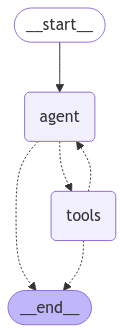

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

`Run the graph` and stream the agent reasoning.

We are going to ask the agent to extract the content from a `specific webpage`.

In [29]:
# Inputs for the agent
inputs = {"messages": [("user", "Find all the latest news related to CES 2025")]}

# Run the graph
for event in graph.stream(inputs, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Find all the latest news related to CES 2025
================================== Ai Message ==================================
Tool Calls:
  urls_finder (call_lXx0Jn0UGLw40zTaT3TK3J35)
 Call ID: call_lXx0Jn0UGLw40zTaT3TK3J35
  Args:
    query: CES 2025 latest news
================================= Tool Message =================================
Name: urls_finder

[{"url": "https://www.techradar.com/tech-events/live/ces-2025-live-latest-news", "content": "Head over to our CES 2025 news page for the latest stories and our hands-on verdicts on everything from 8K TVs and foldable displays to new phones, laptops, smart home gadgets, and the latest in AI. CES 2025 day 1: the 11 best gadgets we've seen, from Samsung's new flagship OLED TV to the Garmin Instinct 3 Read the full story: CES 2025 day 1: the 11 best gadgets we've seen, from Samsung's new flagship OLED TV to the Garmin Instinct 3 This robot vacuum can a

In [30]:
# get last message (assuming the last one is the Smartscraper tool response)
result = graph.get_state(config).values["messages"][-1].content

import json
# convert string into json
result = json.loads(result)

Print the response

In [31]:
print(json.dumps(result, indent=2))

{
  "news": [
    {
      "title": "CES 2025 day 3: the 11 best gadgets we've seen, from Lenovo's rollable laptop to Panasonic's new flagship OLED TV",
      "link": "https://www.techradar.com/tech-events/ces-2025-day-3-the-11-best-gadgets-weve-seen-from-lenovos-rollable-laptop-to-panasonics-new-flagship-oled-tv",
      "description": "A roundup of the top gadgets showcased on the third day of CES 2025, highlighting innovative products from various brands."
    },
    {
      "title": "CES 2025 proves AI is everywhere, unstoppable, and perhaps just how you want it",
      "link": "https://www.techradar.com/computing/artificial-intelligence/ces-2025-proves-ai-is-everywhere-unstoppable-and-perhaps-just-how-you-want-it",
      "description": "An exploration of the pervasive presence of AI technologies at CES 2025 and their implications for consumers."
    },
    {
      "title": "Forget tri-folding phones - this pocketable folding projector is the companion I want for my 2025 travels",
  

## Save output inside a My-SQL db

In [32]:
%%capture
!pip install mysql-connector-python
!apt-get -y install mysql-server

In [33]:
!service mysql start

 * Starting MySQL database server mysqld
su: warning: cannot change directory to /nonexistent: No such file or directory
   ...done.


In [34]:
!mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH 'mysql_native_password' BY 'root';FLUSH PRIVILEGES;"


### Connect to MySQL

In [35]:
import mysql.connector

# Create a connection to the MySQL server
conn = mysql.connector.connect(user='root', password='root', host='localhost')

# Create a cursor to interact with the MySQL server
cursor = conn.cursor()

### Create & Design a Database

In [36]:
# Create a new database named 'articles_db'
cursor.execute("CREATE DATABASE IF NOT EXISTS articles_db")

# Switch to the 'articles_db' database
cursor.execute("USE articles_db")

# Create the 'articles_table' table
cursor.execute('''
CREATE TABLE IF NOT EXISTS articles_table (
    id INT AUTO_INCREMENT PRIMARY KEY,
    title VARCHAR(500) NOT NULL,
    link VARCHAR(500) NOT NULL,
    description TEXT NOT NULL
)
''')

# Always remember to close the cursor and connection when done
cursor.close()
conn.close()

### Populate the database

In [37]:
import mysql.connector

# Connect to the MySQL server and the 'articles_db' database
conn = mysql.connector.connect(user='root', password='root', host='localhost', database='articles_db')
cursor = conn.cursor()

# Prepare the news data for insertion
articles_table_data = [(article["title"], article["link"], article["description"]) for article in result["news"]]

# Insert data using the cursor
cursor.executemany('''
INSERT INTO articles_table (title, link, description) VALUES (%s, %s, %s)
''', articles_table_data)

# Commit the changes
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

### Query the database

In [38]:
import mysql.connector

# Connect to the MySQL server and the 'articles_db' database
conn = mysql.connector.connect(user='root', password='root', host='localhost', database='articles_db')
cursor = conn.cursor()

# Execute the SELECT query
cursor.execute("SELECT * FROM articles_table")

# Fetch all the results
records = cursor.fetchall()

# Print the records
for record in records:
    print(record)

# Close the cursor and connection
cursor.close()
conn.close()

(1, "CES 2025 day 3: the 11 best gadgets we've seen, from Lenovo's rollable laptop to Panasonic's new flagship OLED TV", 'https://www.techradar.com/tech-events/ces-2025-day-3-the-11-best-gadgets-weve-seen-from-lenovos-rollable-laptop-to-panasonics-new-flagship-oled-tv', 'A roundup of the top gadgets showcased on the third day of CES 2025, highlighting innovative products from various brands.')
(2, 'CES 2025 proves AI is everywhere, unstoppable, and perhaps just how you want it', 'https://www.techradar.com/computing/artificial-intelligence/ces-2025-proves-ai-is-everywhere-unstoppable-and-perhaps-just-how-you-want-it', 'An exploration of the pervasive presence of AI technologies at CES 2025 and their implications for consumers.')
(3, 'Forget tri-folding phones - this pocketable folding projector is the companion I want for my 2025 travels', 'https://www.techradar.com/televisions/projectors/forget-tri-folding-phones-this-pocketable-folding-projector-is-the-companion-i-want-for-my-2025-tra

### 💾 Save the output to a `CSV` file

Let's create a pandas dataframe and show the table with the extracted content

In [39]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(result["news"])
df

,title,link,description
0,CES 2025 day 3: the 11 best gadgets we've seen...,https://www.techradar.com/tech-events/ces-2025...,A roundup of the top gadgets showcased on the ...
1,"CES 2025 proves AI is everywhere, unstoppable,...",https://www.techradar.com/computing/artificial...,An exploration of the pervasive presence of AI...
2,Forget tri-folding phones - this pocketable fo...,https://www.techradar.com/televisions/projecto...,A review of a new portable folding projector t...
3,HDMI 2.2 officially revealed at CES 2025: here...,https://www.techradar.com/tech/hdmi-2-2-offici...,Details on the announcement of HDMI 2.2 and it...
4,This awesome E Ink poster frame looks like the...,https://www.techradar.com/home/smart-home/this...,A look at a new E Ink poster frame that repres...
5,"I saw Hisense's RGB mini-LED TV, and this vivi...",https://www.techradar.com/televisions/i-saw-hi...,An impression of Hisense's new RGB mini-LED TV...
6,"I saw Samsung's new The Frame Pro mini-LED TV,...",https://www.techradar.com/televisions/i-saw-sa...,Samsung's The Frame Pro mini-LED TV has been s...
7,This robot vacuum can also bring you a sandwic...,https://www.techradar.com/tech-events/this-rob...,The SwitchBot K20+ Pro is highlighted as a sta...
8,"Nvidia unveils new GeForce RTX 5090, RTX 5080,...",https://www.techradar.com/computing/gpu/nvidia...,Nvidia has revealed its latest RTX 5000 series...
9,"I heard LG's new speakers made with will.i.am,...",https://www.techradar.com/audio/wireless-bluet...,"LG's new range of Bluetooth speakers, develope..."


Save it to CSV

In [40]:
# Save the DataFrame to a CSV file
csv_file = "news.csv"
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

Data saved to news.csv


## 🔗 Resources


<p align="left">
  <img src="https://raw.githubusercontent.com/VinciGit00/Scrapegraph-ai/main/docs/assets/api-banner.png"
       alt="ScrapeGraph API Banner" width="600">
</p>


- 🚀 **Get your API Key:** [ScrapeGraphAI Dashboard](https://dashboard.scrapegraphai.com)  
- 🐙 **GitHub:** [ScrapeGraphAI GitHub](https://github.com/scrapegraphai)  
- 💼 **LinkedIn:** [ScrapeGraphAI LinkedIn](https://www.linkedin.com/company/scrapegraphai/)  
- 🐦 **Twitter:** [ScrapeGraphAI Twitter](https://twitter.com/scrapegraphai)  
- 💬 **Discord:** [Join our Discord Community](https://discord.gg/uJN7TYcpNa)  
- 🦜 **Langchain:** [ScrapeGraph docs](https://python.langchain.com/docs/integrations/tools/scrapegraph/)

Made with ❤️ by the [ScrapeGraphAI](https://scrapegraphai.com) Team  
